In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

## Step 1. Open the data file and study the general information

In [32]:
try:
    cars = pd.read_csv('vehicles_us.csv')
except:
     cars = pd.read_csv('/datasets/vehicles_us.csv')

cars

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51520,9249,2013.0,nissan maxima,like new,6.0,gas,88136.0,automatic,sedan,black,NaN,2018-10-03,37
51521,2700,2002.0,honda civic,salvage,4.0,gas,181500.0,automatic,sedan,white,NaN,2018-11-14,22
51522,3950,2009.0,hyundai sonata,excellent,4.0,gas,128000.0,automatic,sedan,blue,NaN,2018-11-15,32
51523,7455,2013.0,toyota corolla,good,4.0,gas,139573.0,automatic,sedan,black,NaN,2018-07-02,71


In [33]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         51525 non-null  int64  
 1   model_year    47906 non-null  float64
 2   model         51525 non-null  object 
 3   condition     51525 non-null  object 
 4   cylinders     46265 non-null  float64
 5   fuel          51525 non-null  object 
 6   odometer      43633 non-null  float64
 7   transmission  51525 non-null  object 
 8   type          51525 non-null  object 
 9   paint_color   42258 non-null  object 
 10  is_4wd        25572 non-null  float64
 11  date_posted   51525 non-null  object 
 12  days_listed   51525 non-null  int64  
dtypes: float64(4), int64(2), object(7)
memory usage: 5.1+ MB


## Step 2. Data preprocessing

### — Identify and study missing values:

In [34]:
cars.isnull().sum()

price               0
model_year       3619
model               0
condition           0
cylinders        5260
fuel                0
odometer         7892
transmission        0
type                0
paint_color      9267
is_4wd          25953
date_posted         0
days_listed         0
dtype: int64

In [35]:
cars['model_year'].fillna(cars.groupby('model')['model_year'].transform('mean'), inplace=True)

In [36]:
cars['cylinders'].fillna(cars.groupby('model')['cylinders'].transform('median'), inplace=True)

In [37]:
cars['odometer'].fillna(cars.groupby('model_year')['odometer'].transform('mean'), inplace=True)
cars['odometer'].fillna(value=0, inplace=True) #one last nan value was replaced by 0

In [38]:
cars['paint_color'].fillna(value='N/A', inplace=True)

In [39]:
cars['is_4wd'].fillna(value=0, inplace=True)

In [40]:
cars.isnull().sum() # checking if there are still any missing values left

price           0
model_year      0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
transmission    0
type            0
paint_color     0
is_4wd          0
date_posted     0
days_listed     0
dtype: int64

### About missing values:

#### model_year column missing values were replaced by the mean number of years per model.
#### cylinders column missing value were replaced by the median number of the amount of cylinders per model
#### odometer column missing values were replaced by the mean number of the odometer counts per model_year group. after the replacement there were one missing value left. the model_year value related to the car only had one single representant (model_year == 1929), therefore the program was unable to calculate the mean odometer value. It was replaced manually by 0.

#### all of the above columns I considered as MAR values as they could be estimated based on other information provided in the table.

#### paint_color colums missing values were assigned N/A because is not possible to find out the color of each car, even though the models could be exactly equal in all other columns. Moreover, so far, there is no need to know the exact color. MCAR value

#### is_4wd column missing values were assigned 0 (False) because the only other option is True, embracing half of the table. MNAR value.

#### I believe the missing values were so frequent due to  the subject of the the table. These are very solid data that is usually found in every vehicle documents. If the person doesn't have access to these documents, very likely this could be the reason to such missing values.

### — Convert the data to the required types:

In [41]:
cars['model_year'] = cars['model_year'].astype(int)
cars['cylinders'] = cars['cylinders'].astype(int)
cars['odometer'] = cars['odometer'].astype(int)
cars['is_4wd'] = cars['is_4wd'].astype(int)
cars['date_posted'] = pd.to_datetime(cars['date_posted'], format='%Y-%m-%d')

In [42]:
cars.dtypes

price                    int64
model_year               int64
model                   object
condition               object
cylinders                int64
fuel                    object
odometer                 int64
transmission            object
type                    object
paint_color             object
is_4wd                   int64
date_posted     datetime64[ns]
days_listed              int64
dtype: object

In [43]:
cars.duplicated().sum()

0

#### There is no reason for model_year, cylinders and is_4wd to be floating points since the two first columns show round numbers and the third one shows a boolean value. The odometer column could be a floating point, but is already rounded up to facilitate the reading. They were all converted to integer to match the table and facilitate future manipulations. Also, no duplicate was found

#### date_posted column was converted to datetime datatype to match the next task.

## Step 3. Calculate and add to the table the following:

### Day of the week, month, and year the ad was placed

In [44]:
cars['date_posted'] = pd.to_datetime(cars['date_posted']).apply(lambda x: pd.datetime.strftime(x,'%d/%m/%y'))
# date rearranged to the correct display
weekday = pd.DatetimeIndex(cars['date_posted']).day_name().astype(str)
month = pd.DatetimeIndex(cars['date_posted']).month_name().astype(str)
year_str = pd.DatetimeIndex(cars['date_posted']).year.astype(str)
year_num = pd.DatetimeIndex(cars['date_posted']).year #different dtype 
# day of the week, month and year were extracted

In [45]:
cars['ad_placed'] = weekday.str.cat(month, sep=' ')
cars['ad_placed'] = cars['ad_placed'].str.cat(year_str, sep=' ')
cars
# day of the week, month and year converted to strings and ad_placed column created with the required data

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed,ad_placed
0,9400,2011,bmw x5,good,6,gas,145000,automatic,SUV,N/A,1,23/06/18,19,Saturday June 2018
1,25500,2009,ford f-150,good,6,gas,88705,automatic,pickup,white,1,19/10/18,50,Friday October 2018
2,5500,2013,hyundai sonata,like new,4,gas,110000,automatic,sedan,red,0,07/02/19,79,Tuesday July 2019
3,1500,2003,ford f-150,fair,8,gas,162071,automatic,pickup,N/A,0,22/03/19,9,Friday March 2019
4,14900,2017,chrysler 200,excellent,4,gas,80903,automatic,sedan,black,0,02/04/19,28,Monday February 2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51520,9249,2013,nissan maxima,like new,6,gas,88136,automatic,sedan,black,0,03/10/18,37,Saturday March 2018
51521,2700,2002,honda civic,salvage,4,gas,181500,automatic,sedan,white,0,14/11/18,22,Wednesday November 2018
51522,3950,2009,hyundai sonata,excellent,4,gas,128000,automatic,sedan,blue,0,15/11/18,32,Thursday November 2018
51523,7455,2013,toyota corolla,good,4,gas,139573,automatic,sedan,black,0,02/07/18,71,Wednesday February 2018


## The vehicle's age (in years) when the ad was placed

In [46]:
cars['car_age'] = year_num - cars['model_year']
#a new column with the vehicle's age was created

### The vehicle's average mileage per year

In [47]:
cars['mileage'] = (cars['odometer'] / cars['car_age']).round(0)
#new column with the vehicle's average mileage per year was created


In [48]:
# need to replace mileage inf values with odometer values
cars['mileage'] = np.where(cars['car_age'] == 0,cars.odometer, cars.mileage )

### In the condition column, replace string values with a numeric scale:
### new = 5
### like new = 4
### excellent = 3
### good = 2
### fair = 1
### salvage = 0

In [49]:
def num_condition(condition):
    if 'new' in condition:
        return 5 
    if 'like new' in condition:
        return 4
    if 'excellent' in condition:
        return 3
    if 'good' in condition:
        return 2
    if 'fair' in condition:
        return 1
    elif 'salvage' in condition:
        return 0
    else:
        return 'Not Applicable' # in case of an outlier

cars['condition'] = cars['condition'].apply(num_condition)
cars['condition'].value_counts() # checks if there is any outliner

3    24773
2    20145
5     4885
1     1607
0      115
Name: condition, dtype: int64

In [50]:
cars.isnull().sum() #checking for new missing values after the creation and modification of 3 columns.

price           0
model_year      0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
transmission    0
type            0
paint_color     0
is_4wd          0
date_posted     0
days_listed     0
ad_placed       0
car_age         0
mileage         0
dtype: int64

In [51]:
cars[cars.isna().any(axis=1)] #checking the rows where missing values appears
cars['mileage'].fillna(value=0, inplace=True) #missing values replaced by 0.
#missing values that resulted from the creation of mileage column. model year is the same as the year of the placed ad and the odometer is 0. Brand new vehicle, therefore no mileage value.

## Step 4. Carry out exploratory data analysis, following the instructions below:


### - Study the following parameters: price, vehicle's age when the ad was placed, mileage, number of cylinders, and condition. Plot histograms for each of these parameters. Study how outliers affect the form and readability of the histograms.

### - Determine the upper limits of outliers, remove the outliers and store them in a separate DataFrame, and continue your work with the filtered data.

In [52]:
outliers = pd.DataFrame()

,price,model_year,condition,cylinders,odometer,is_4wd,days_listed,car_age,mileage
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,113670.883721,2010.651163,3.418605,7.162791,71362.651163,0.604651,39.046512,7.674419,14895.674419
std,66780.162830,11.745077,1.366827,1.089566,72584.257669,0.494712,24.124630,11.859738,11954.106218
min,65500.000000,1964.000000,1.000000,4.000000,35.000000,0.000000,4.000000,0.000000,2.000000
25%,67750.000000,2007.500000,2.000000,6.000000,8994.500000,0.000000,21.000000,0.000000,6250.500000
50%,79900.000000,2014.000000,3.000000,8.000000,29000.000000,1.000000,34.000000,4.000000,11600.000000
75%,131728.000000,2018.000000,5.000000,8.000000,142639.500000,1.000000,54.000000,11.000000,24328.000000
max,375000.000000,2019.000000,5.000000,8.000000,249000.000000,1.000000,102.000000,55.000000,44000.000000


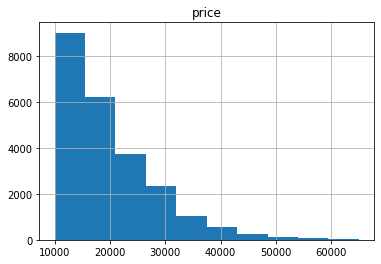

In [53]:
price_hist = cars.hist('price', range=(10000, 65000)) # raw histogram of price column
filtered_price_hist = cars.query('price > 65000').describe()
filtered_price_hist #filtered histogram of price column
#outliers['price'] = filtered_price_hist

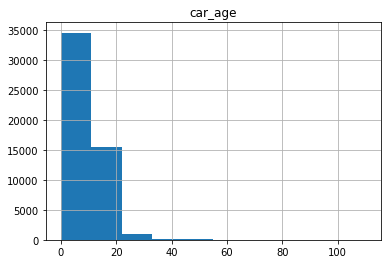

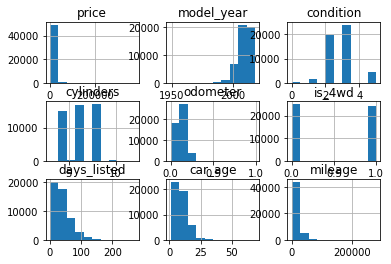

In [54]:
cars.hist('car_age')
filtered_age_hist = cars.query('car_age > 0 and car_age < 70').hist()

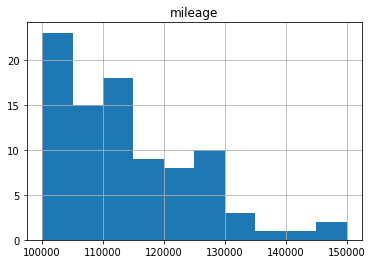

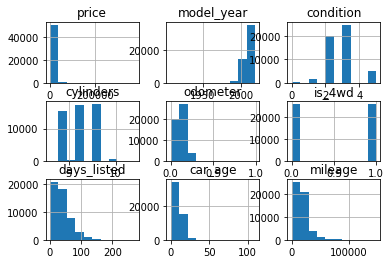

In [55]:
cars.hist('mileage', range=(100000, 150000))
filtered_mileage_hist = cars.query('mileage > 0 and mileage < 150000').hist()

array([[<AxesSubplot:title={'center':'cylinders'}>]], dtype=object)

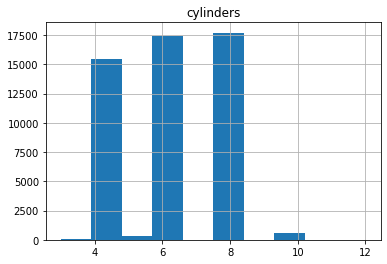

In [56]:
cars.hist('cylinders')

array([[<AxesSubplot:title={'center':'condition'}>]], dtype=object)

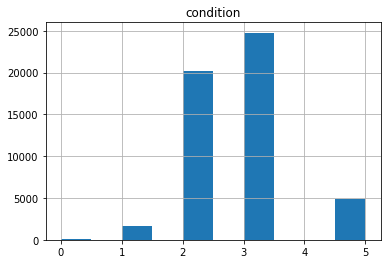

In [57]:
cars.hist('condition')